### Autore: Ahmed Riaz Luis
### Codice persona: 10372022

##Wi-Fi encrypted traffic classification

implement a machine-learning classifier able
to distinguish what kind of activity a user is performing with his/her
smartphone/laptop by sniffing traffic in monitor mode. The system should perform
the following operations:
<ul>
<li> Sniff traffic in monitor mode from a known MAC address </li>
<li> Extract statistical features from the traffic every W seconds. The following
traffic features can be extracted: number of packets up/down, average and
variance of the packet size, average and variance of the inter-arrival packet
times etc.
<li> Use a pre-trained machine-learning classifier of your choice to recognize the
user activity among at least the following: idle, web browsing, YouTube
streaming.</li>
<li> Report the accuracy of the approach through a confusion matrix </br>
Reference: https://ieeexplore.ieee.org/abstract/document/8543584 </li>
</ul>



As a first step we mount the google drive folder with our captures. Note that we could as well manually upload the captures to the colab files folder but the former option was preferred because it avoids wasting time at every runtime restart and it's also simpler because it allows the code to work directly on the folder (cycling through the filenames) without needing to create everytime a new folder with the captures (colab doesn't allow to upload folders directly on the workspace but only in the google drive storage)

In [1]:
from google.colab import drive
import pandas as pd

#if mounted from google drive
drive.mount('/content/drive')

Mounted at /content/drive


####Method used for the capture
802.11 frames were captured by putting the wireless interface of the device in monitor mode. This was accomplished in Ubuntu 22.04 OS by writing the following commands in the terminal:

*sudo iwconfig wlo1* -- configuration and channel used in network connection <br>
*sudo iwlist wlo1 channel* -- list of available 802.11 channels <br>
*sudo airmon-ng check kill* - kill network manager <br>
*sudo airmon-ng start wlo1* x	-- start wlo1mon at channel “x” (x can be 1, 6, 52 for example) <br>
*sudo wireshark* -- start wireshark <br>
*sudo airmon-ng stop wlo1mon* – stop airmon-ng wlo1mon <br>
*sudo service NetworkManager start * --restart network manager to enable wifi

In the configuration of the network connection it could be noticed that channel 52 was being used for frames exchange by the selected router and the devices connected to it, although beacon frames were also sent through other channels; as a result the wlo1mon monitoring interface was started at channel 52. Captures were done every 20 seconds. Different actions were performed during the capture:
<ul>
<li>youtube video streaming</li>
<li>web browsing</li>
<li>idle (screen off)</li>
<li>whatsapp call</li>
</ul>

The target devices are a Xiaomi phone and a ZyxelCom router. <br>
A sample of the captured frames is displayed.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/WI_traffic_captures_new/browsing_1.csv')
display(df)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,ZyxelCom_6a:85:02,Broadcast,802.11,414,"Beacon frame, SN=1289, FN=0, Flags=........C, ..."
1,2,0.080242,22:19:54:71:1a:09,Broadcast,802.11,474,"Beacon frame, SN=1602, FN=0, Flags=........C, ..."
2,3,0.102566,ZyxelCom_6a:85:02,Broadcast,802.11,414,"Beacon frame, SN=1290, FN=0, Flags=........C, ..."
3,4,0.182292,22:19:54:71:1a:09,Broadcast,802.11,474,"Beacon frame, SN=1603, FN=0, Flags=........C, ..."
4,5,0.182881,22:19:54:71:1a:0b,Broadcast,802.11,432,"Beacon frame, SN=2063, FN=0, Flags=........C, ..."
...,...,...,...,...,...,...,...
4756,4757,20.008547,XiaomiCo_72:b0:52,ZyxelCom_6a:85:02,802.11,86,"QoS Null function (No data), SN=1411, FN=0, Fl..."
4757,4758,20.008573,NaN,XiaomiCo_72:b0:52 (64:a2:00:72:b0:52) (RA),802.11,70,"Acknowledgement, Flags=........C"
4758,4759,20.033763,XiaomiCo_72:b0:52,ZyxelCom_6a:85:02,802.11,86,"QoS Null function (No data), SN=1412, FN=0, Fl..."
4759,4760,20.033795,NaN,XiaomiCo_72:b0:52 (64:a2:00:72:b0:52) (RA),802.11,70,"Acknowledgement, Flags=........C"


  #### Features extraction
 The extract_features function takes into account the time difference between the arrivals of the packets of a single frame, namely it computes the minimum, maximum, average, standard deviation of the inter-arrival times in the frame.


In [3]:
def extract_features(flow,df_flow):

  flow_features = {}

  iat = pd.to_datetime(df_flow['Time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()

  return flow_features


#### Dataset creation
The dataset is prepared by parsing all the files in the google-drive directory and by creating, for each file, a group of 802.11 flows which is then appended to the dataset with a label taken from the name of the file itself. Note that only downlink flows with addresses of the target devices were chosen to be appended to the dataset.

In [4]:
from os import listdir
from os.path import isfile, join
import numpy as np

path = '/content/drive/MyDrive/WI_traffic_captures_new' #path to the google-drive directory
dir_files = [f for f in listdir(path) if isfile(join(path, f))] #collect the filenames in the dir_files array
apps = np.unique([f.split('_')[0] for f in dir_files])

dataset = pd.DataFrame() #a new dataset pandas data frame is created

#Reads all the files in the google-drive directory and creates multiple flows for each file, each of which is a structure made by an array
#which represents the fields selected for the grouping ('Source' and 'Destination) and the data frame with the grouped frames.
#The features which are useful for the classification are extracted through the extract_features function and a new flow_features frame
#is created, the label is added to the frame by parsing the filename of the file from which the flow was created and the newly created frame is appended to
#the dataset data frame previously created.
for f in dir_files:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_flows = df.groupby(["Source","Destination"])
  for flow,df_flow in df_flows: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = f.split('_')[0];
    if((flow[0].split('_')[0]=='ZyxelCom' and flow[1].split('_')[0]=='XiaomiCo')): #only downlink flows are considered
      dataset = dataset.append(flow_features,ignore_index=True);


display(dataset)

Processing file   idle_16.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_25.csv
Processing file   idle_33.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_14.csv
Processing file   youtube_6.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_18.csv
Processing file   idle_31.csv
Processing file   whatsapp_22.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_13.csv
Processing file   whatsapp_27.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_7.csv
Processing file   youtube_22.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_4.csv
Processing file   youtube_18.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_5.csv
Processing file   youtube_9.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_26.csv
Processing file   whatsapp_28.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_29.csv
Processing file   idle_26.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_6.csv
Processing file   youtube_2.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_11.csv
Processing file   youtube_8.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_19.csv
Processing file   idle_7.csv
Processing file   youtube_30.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_39.csv
Processing file   whatsapp_16.csv
Processing file   youtube_12.csv
Processing file   youtube_33.csv
Processing file   youtube_27.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_2.csv
Processing file   idle_10.csv
Processing file   youtube_23.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_5.csv
Processing file   youtube_15.csv
Processing file   whatsapp_5.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_30.csv
Processing file   whatsapp_3.csv
Processing file   whatsapp_30.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_38.csv
Processing file   whatsapp_20.csv
Processing file   idle_1.csv
Processing file   idle_21.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_9.csv
Processing file   whatsapp_23.csv
Processing file   youtube_31.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_20.csv
Processing file   youtube_26.csv
Processing file   idle_9.csv
Processing file   idle_35.csv
Processing file   idle_27.csv
Processing file   youtube_19.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_35.csv
Processing file   whatsapp_29.csv
Processing file   whatsapp_17.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_2.csv
Processing file   whatsapp_13.csv
Processing file   idle_12.csv
Processing file   browsing_3.csv
Processing file   browsing_4.csv
Processing file   idle_4.csv
Processing file   whatsapp_12.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is depreca

Processing file   youtube_3.csv
Processing file   browsing_19.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   idle_28.csv
Processing file   youtube_7.csv
Processing file   whatsapp_24.csv
Processing file   whatsapp_15.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_4.csv
Processing file   youtube_10.csv
Processing file   whatsapp_19.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_34.csv
Processing file   browsing_1.csv
Processing file   idle_24.csv
Processing file   idle_14.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_9.csv
Processing file   idle_34.csv
Processing file   idle_23.csv
Processing file  

<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


 idle_40.csv
Processing file   idle_32.csv
Processing file   idle_8.csv
Processing file   idle_3.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_25.csv
Processing file   browsing_2.csv
Processing file   idle_17.csv
Processing file   whatsapp_18.csv
Processing file   whatsapp_14.csv
Processing file   whatsapp_10.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_11.csv
Processing file   idle_11.csv
Processing file   idle_15.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_40.csv
Processing file   whatsapp_8.csv
Processing file   whatsapp_1.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   whatsapp_6.csv
Processing file   youtube_32.csv
Processing file   idle_37.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_5.csv
Processing file   whatsapp_21.csv
Processing file   idle_22.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_36.csv
Processing file   browsing_28.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_26.csv
Processing file   youtube_17.csv
Processing file   youtube_25.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_8.csv
Processing file   youtube_16.csv
Processing file   browsing_15.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_17.csv
Processing file   browsing_25.csv
Processing file   idle_36.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_20.csv
Processing file   youtube_20.csv
Processing file   youtube_39.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_37.csv
Processing file   browsing_22.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_1.csv
Processing file   browsing_13.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_11.csv
Processing file   browsing_27.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_29.csv
Processing file   browsing_16.csv
Processing file   browsing_21.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_29.csv
Processing file   youtube_38.csv
Processing file   browsing_30.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_12.csv
Processing file   youtube_28.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_10.csv
Processing file   youtube_13.csv
Processing file   browsing_7.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   browsing_18.csv
Processing file   browsing_23.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


Processing file   youtube_21.csv
Processing file   youtube_24.csv
Processing file   browsing_14.csv
Processing file   browsing_24.csv
Processing file   browsing_6.csv


<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-4-3a7dd4a9c83c>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);


,min_iat,max_iat,mean_iat,std_iat,app
0,1.000000e-09,4.000000e-09,2.500000e-09,2.121320e-09,idle
1,0.000000e+00,5.000000e-09,1.666667e-09,2.886751e-09,idle
2,0.000000e+00,5.000000e-09,2.958580e-11,3.459426e-10,youtube
3,0.000000e+00,3.000000e-09,2.380952e-11,2.138121e-10,youtube
4,0.000000e+00,5.000000e-09,1.363636e-10,7.652605e-10,idle
...,...,...,...,...,...
135,0.000000e+00,5.000000e-09,1.763485e-11,2.383314e-10,youtube
136,0.000000e+00,4.000000e-09,1.002950e-11,1.590065e-10,youtube
137,0.000000e+00,1.000000e-09,2.885345e-12,5.364194e-11,browsing
138,0.000000e+00,2.000000e-09,5.884084e-12,8.024814e-11,browsing


#### Training and evaluation
The dataset is divided in a training set which takes 80% of data and an evaluation set which takes 20% of data. The evaluation set is then used to create a confusion matrix.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample


from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import  classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


#constructing features
le = LabelEncoder();
scaler = StandardScaler();


#using only traffic features
X = dataset.dropna();



Y = le.fit_transform(X['app']);
X = X.drop('app',axis=1);

X_norm = scaler.fit_transform(X);


#now let's use a stratified k-fold cross validation approach with 5 splits
tot_cm = np.zeros([len(apps),len(apps)])
skf = StratifiedKFold(n_splits=5,shuffle=True)
print('KNN')
for train, test in skf.split(X_norm, Y):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_norm[train], Y[train])
    knn_predict = knn.predict(X_norm[test])
    knn_report = classification_report(Y[test],knn_predict,target_names=le.inverse_transform(np.arange(len(apps))),digits=3,output_dict=True)
    fold_accuracy = knn_report['accuracy']
    print(fold_accuracy)
    cm = confusion_matrix(Y[test],knn.predict(X_norm[test]))
    tot_cm = tot_cm + cm;


KNN
0.8846153846153846
0.8846153846153846
0.96
0.92
0.92


The confusion matrix is displayed.

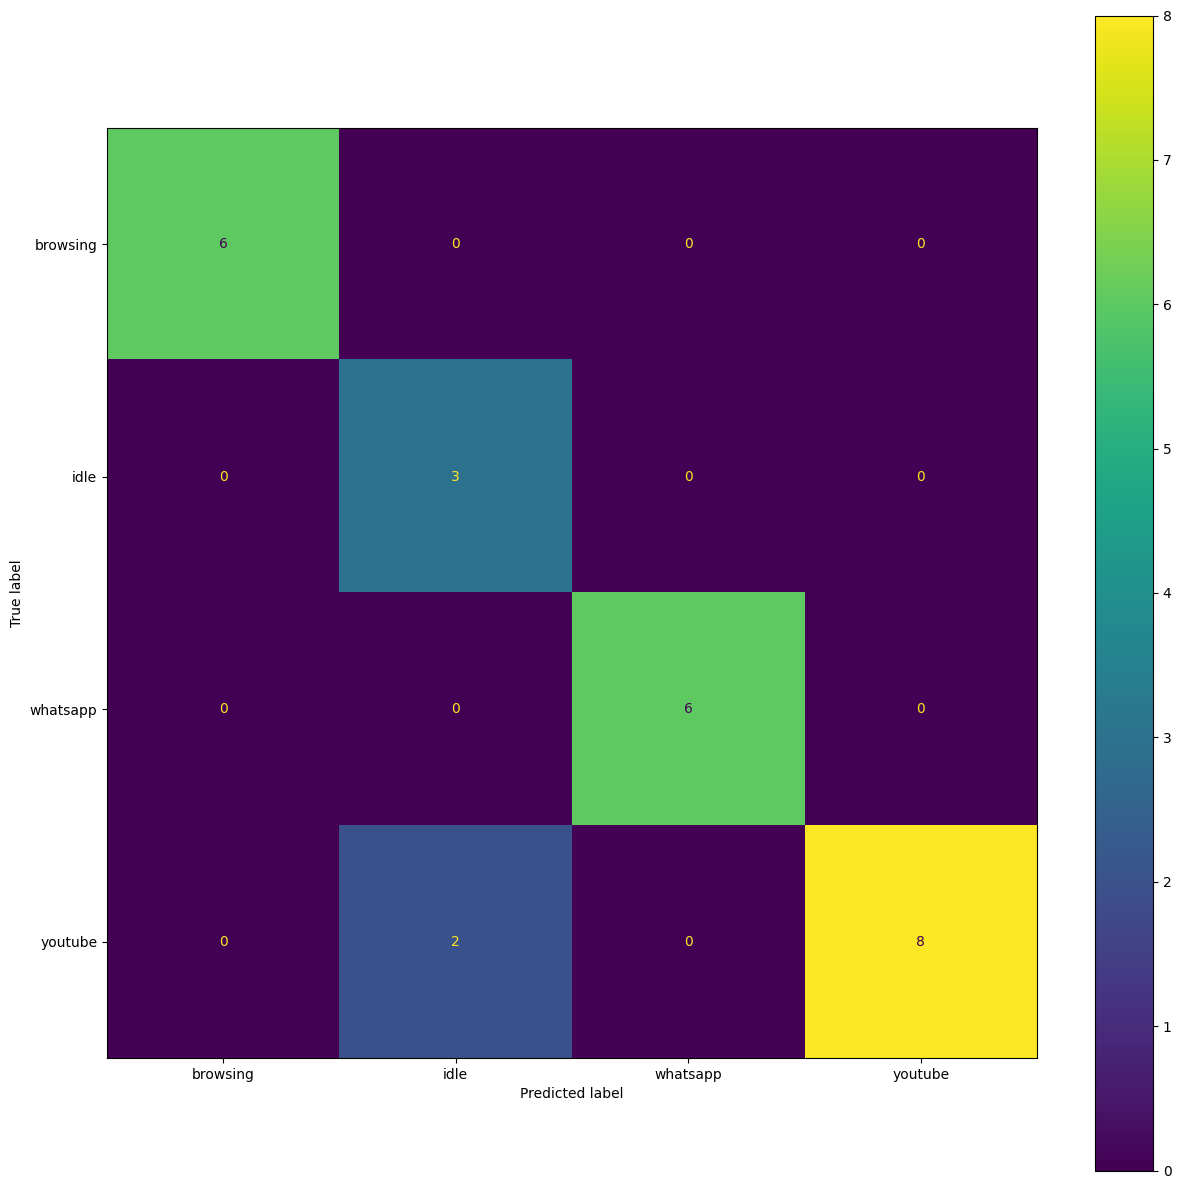

In [6]:
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(knn_predict, Y[test], ax=ax, display_labels=le.inverse_transform(np.arange(len(apps))));
